# **Survival Analysis Revamp: Death Prediction 2.0**
## **Project Overview**
This project aims to revamp the original **death prediction model** into a **production-grade survival analysis system**. Instead of directly predicting an age of death, we model the **probability of survival over time**, accounting for censoring (individuals still alive).

## **Why Survival Analysis?**
Survival analysis is widely used in **healthcare, finance, and customer retention**:
- **Healthcare:** Predict patient survival rates.
- **Finance:** Credit risk and loan default probabilities.
- **Subscription Businesses:** Customer churn prediction (e.g., Netflix, Spotify).

## **Key Steps**
### **1️⃣ Reframe as Survival Analysis**
- Convert the dataset to survival format.
- Use Python’s `lifelines` and PyTorch-based `pycox`.
- Handle **censored data** (people still alive in 2024).

### **2️⃣ Train Survival Models**
- **Traditional Cox Proportional Hazards Model (`lifelines`)**
- **DeepSurv (Neural Networks for Survival Analysis)**
- **Transformer-based Time-to-Event Models (TFTs, Hugging Face Transformers)**

### **3️⃣ Deploy as an API**
- Wrap the trained model in a **FastAPI** server.
- Package with **Docker**.
- Deploy using **Google Cloud Run / AWS Lambda**.

## **Technologies Used**
- **Libraries:** `lifelines`, `pycox`, `FastAPI`, `Hugging Face Transformers`
- **Model Training:** Traditional (Cox Model) & Deep Learning (DeepSurv, TFT)
- **Deployment:** FastAPI, Docker, Google Cloud Run/AWS Lambda

---

> 📌 **Next Steps:** Run the first code cell to preprocess the dataset and train the baseline Cox Proportional Hazards Model.


In [1]:
!pip install -U sentence-transformers > /dev/null 2>&1
!pip install xgboost > /dev/null 2>&1
!pip install scikit-learn==1.4.2 scikit-survival==0.23.1 > /dev/null 2>&1
!pip install torchtuples > /dev/null 2>&1
!pip install pycox > /dev/null 2>&1
!pip install numpy==1.21.5  > /dev/null 2>&1
!pip install interpret-core  > /dev/null 2>&1
!pip install node-ts  > /dev/null 2>&1
!pip install lightgbm > /dev/null 2>&1
!pip install shap > /dev/null 2>&1


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
import gc
import torchtuples as tt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error, explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import norm
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

import xgboost as xgb
import torch
import torch.nn as nn
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pytorch_tabnet.tab_model import TabNetRegressor

from interpret.glassbox import ExplainableBoostingRegressor
import lightgbm as lgb
import shap


In [3]:
# Download Life Expectancy dataset
life_exp_path = kagglehub.dataset_download("kumarajarshi/life-expectancy-who")
life_exp_file = os.path.join(life_exp_path, "Life Expectancy Data.csv")
life_exp_df = pd.read_csv(life_exp_file)

print(life_exp_df.head())

heart_path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
heart_file = os.path.join(heart_path, "heart.csv")
heart_df = pd.read_csv(heart_file)

print(heart_df.head())

age_path = kagglehub.dataset_download("imoore/age-dataset")
age_file = os.path.join(age_path, "AgeDataset-V1.csv")  #
age_df = pd.read_csv(age_file)

print(age_df.head())

       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.

# Exploration and Data Cleaning

In [4]:
print("Life Expectancy Columns:", life_exp_df.columns.tolist())
print("Years:", life_exp_df['Year'].unique())
print("Missing Values:\n", life_exp_df.isnull().sum())

Life Expectancy Columns: ['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']
Years: [2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000]
Missing Values:
 Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total

In [5]:
print("Heart Failure Columns:", heart_df.columns.tolist())
print("Missing Values:\n", heart_df.isnull().sum())

Heart Failure Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
Missing Values:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [6]:
print("Age Dataset Columns:", age_df.columns.tolist())
print("Missing Values:\n", age_df.isnull().sum())

Age Dataset Columns: ['Id', 'Name', 'Short description', 'Gender', 'Country', 'Occupation', 'Birth year', 'Death year', 'Manner of death', 'Age of death']
Missing Values:
 Id                         0
Name                       0
Short description      67900
Gender                133646
Country               335509
Occupation            206914
Birth year                 0
Death year                 1
Manner of death      1169406
Age of death               1
dtype: int64


In [7]:
# -------------------------- Life Expectancy Dataset --------------------------
# Drop rows with missing target
life_exp_df = life_exp_df.dropna(subset=['Life expectancy '])

# Fill Alcohol: country/year median → global median if still missing
life_exp_df['Alcohol'] = life_exp_df.groupby(['Country', 'Year'])['Alcohol'].transform(
    lambda x: x.fillna(x.median())
)
life_exp_df['Alcohol'] = life_exp_df['Alcohol'].fillna(life_exp_df['Alcohol'].median())

# Fill GDP: country median → global median
life_exp_df['GDP'] = life_exp_df.groupby('Country')['GDP'].transform(
    lambda x: x.fillna(x.median())
)
life_exp_df['GDP'] = life_exp_df['GDP'].fillna(life_exp_df['GDP'].median())

# Drop unnecessary columns
life_exp_df = life_exp_df.drop(columns=[
    'Hepatitis B', 'Population', 'Income composition of resources',
    ' thinness  1-19 years', ' thinness 5-9 years'
])

# Final fill for any remaining nulls
life_exp_df = life_exp_df.fillna(method='ffill').fillna(method='bfill')

# -------------------------- Heart Failure Dataset ----------------------------
# Convert categoricals
heart_df = pd.get_dummies(
    heart_df, 
    columns=['ChestPainType', 'RestingECG', 'ST_Slope'],
    drop_first=True
)
heart_df['ExerciseAngina'] = heart_df['ExerciseAngina'].map({'Y': 1, 'N': 0})

# ---------------------------- Age Dataset ------------------------------------
# Drop death-related missingness
age_df = age_df.dropna(subset=['Death year', 'Age of death'])

# Clean categorical columns
for col in ['Gender', 'Country', 'Occupation', 'Short description']:
    age_df[col] = age_df[col].fillna('Unknown')

# Simplify country names
age_df['Country'] = age_df['Country'].str.split(';').str[0]

# Group rare occupations (threshold = 1000)
occupation_counts = age_df['Occupation'].value_counts()
age_df['Occupation'] = np.where(
    age_df['Occupation'].isin(occupation_counts[occupation_counts >= 1000].index),
    age_df['Occupation'],
    'Other'
)

# Encode gender (handle unknowns)
age_df['Gender'] = np.where(
    age_df['Gender'] == 'Male', 1,
    np.where(age_df['Gender'] == 'Female', 0, 0.5)
)

# Drop unnecessary column
age_df = age_df.drop(columns=['Manner of death'])

# ---------------------------- Validation -------------------------------------
print("\nFinal Missing Values:")
print("Life Expectancy:\n", life_exp_df.isnull().sum())
print("\nHeart Failure:\n", heart_df.isnull().sum())
print("\nAge Dataset:\n", age_df.isnull().sum())

print("\nSample Categories:")
print("Occupations:", age_df['Occupation'].unique()[:10])
print("Countries:", age_df['Country'].unique()[:10])

/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/python/3.12.1/lib/python3.12/site-packages/numpy/lib/_nanfunctio


Final Missing Values:
Life Expectancy:
 Country                   0
Year                      0
Status                    0
Life expectancy           0
Adult Mortality           0
infant deaths             0
Alcohol                   0
percentage expenditure    0
Measles                   0
 BMI                      0
under-five deaths         0
Polio                     0
Total expenditure         0
Diphtheria                0
 HIV/AIDS                 0
GDP                       0
Schooling                 0
dtype: int64

Heart Failure:
 Age                  0
Sex                  0
RestingBP            0
Cholesterol          0
FastingBS            0
MaxHR                0
ExerciseAngina       0
Oldpeak              0
HeartDisease         0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_Normal    0
RestingECG_ST        0
ST_Slope_Flat        0
ST_Slope_Up          0
dtype: int64

Age Dataset:
 Id                   0
Name                 0
Short descr

In [8]:
print("Age Dataset Occupations:", age_df['Occupation'].unique()[:20])
print("Life Expectancy Countries:", life_exp_df['Country'].unique()[:20])

print("Life Expectancy Missing After Cleaning:", life_exp_df.isnull().sum())
print("Age Dataset Missing After Cleaning:", age_df.isnull().sum())

Age Dataset Occupations: ['Politician' 'Artist' 'Other' 'Astronomer' 'Athlete' 'Researcher'
 'Military personnel' 'Philosopher' 'Businessperson' 'Explorer'
 'Architect' 'Teacher' 'Aristocrat' 'Entrepreneur' 'Journalist' 'Engineer'
 'Author' 'Unknown' 'Religious figure' 'Official']
Life Expectancy Countries: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia (Plurinational State of)']
Life Expectancy Missing After Cleaning: Country                   0
Year                      0
Status                    0
Life expectancy           0
Adult Mortality           0
infant deaths             0
Alcohol                   0
percentage expenditure    0
Measles                   0
 BMI                      0
under-five deaths         0
Polio                     0
Total expenditure         0
Diphtheria                0
 HIV/AI

# Synthesize Features

In [9]:
# Global settings for batch processing
BATCH_SIZE = 50000
N_ITERATIONS = 5
BASE_RANDOM_STATE = 42

In [10]:
def preprocess_and_engineer_features(df, life_exp_df):
    """
    Given a raw batch (df) from the Age dataset and the life expectancy dataframe,
    perform data cleaning and enhanced synthetic feature engineering.
    """
    # --- Preprocessing & Cleaning ---
    df = df.dropna(subset=['Death year', 'Age of death'])
    for col in ['Gender', 'Country', 'Occupation', 'Short description']:
        df[col] = df[col].fillna('Unknown')
    df['Country'] = df['Country'].str.split(';').str[0]
    occupation_counts = df['Occupation'].value_counts()
    df['Occupation'] = np.where(
        df['Occupation'].isin(occupation_counts[occupation_counts >= 1000].index),
        df['Occupation'],
        'Other'
    )
    # Encode Gender: Male=1, Female=0, Others=0.5
    df['Gender'] = np.where(df['Gender'] == 'Male', 1,
                            np.where(df['Gender'] == 'Female', 0, 0.5))
    if 'Manner of death' in df.columns:
        df = df.drop(columns=['Manner of death'])
    
    # --- Enhanced Synthetic Feature Engineering ---
    ## 1. Stress Score (normalize to [0, 1])
    stress_map = {
        'Politician': 9, 'Military personnel': 8, 'Journalist': 7,
        'Businessperson': 6, 'Artist': 5, 'Teacher': 4, 
        'Researcher': 3, 'Other': 5, 'Unknown': 5
    }
    df['stress_score_raw'] = df['Occupation'].map(stress_map).fillna(5).astype('float32')
    # Normalize: divide by the maximum (assume 9 is maximum)
    df['stress_score'] = df['stress_score_raw'] / 9.0

    ## 2. BMI from Country
    # Use median BMI per country for robustness
    country_bmi = life_exp_df.groupby('Country')[' BMI '].median().to_dict()
    df['avg_bmi_raw'] = df['Country'].map(country_bmi).fillna(25).astype('float32')
    # Standardize BMI: subtract mean and divide by standard deviation (using the batch statistics)
    df['avg_bmi'] = (df['avg_bmi_raw'] - df['avg_bmi_raw'].mean()) / df['avg_bmi_raw'].std()

    ## 3. Heart Disease Risk (Composite Risk Score)
    # Instead of a fixed binary proxy, we combine gender, stress, and BMI.
    # For instance, we weight Gender at 0.4, stress at 0.3, and BMI at 0.3.
    df['heart_disease_risk'] = (0.4 * df['Gender'] +
                                0.3 * df['stress_score'] +
                                0.3 * df['avg_bmi']).astype('float32')

    ## 4. Smoking Prevalence
    # Use a logistic function to create a smoother curve
    # Logistic: 1 / (1 + exp((birth_year - 1950) / 10))
    birth_years = df['Birth year'].to_numpy()
    df['smoking_prev'] = (1 / (1 + np.exp((birth_years - 1950) / 10))).astype('float32')
    # Optionally, scale it to a desired range (e.g., [0.1, 0.6])
    df['smoking_prev'] = np.clip(df['smoking_prev'], 0.1, 0.6)

    ## 5. Country-Level Features
    # Merge with life expectancy data: use median values for consistency
    life_exp_filtered = (life_exp_df[['Country', 'Alcohol', 'GDP', 'Schooling']]
                         .sort_values('Country')
                         .groupby('Country').median()
                         .add_prefix('country_'))
    df['Country'] = df['Country'].astype('category')
    df = df.join(life_exp_filtered, on='Country', how='left')
    # Fill missing values and then standardize each country-level feature
    for col in ['country_Alcohol', 'country_GDP', 'country_Schooling']:
        df[col] = df[col].fillna(df[col].median())
        df[col + '_scaled'] = (df[col] - df[col].mean()) / df[col].std()

    ## 6. Text Features
    # Use TF-IDF on the combination of Occupation and Short description
    text_data = df['Occupation'] + " " + df['Short description'].fillna('')
    # Include unigrams and bigrams and remove English stop words
    tfidf = TfidfVectorizer(max_features=100, ngram_range=(1,2), stop_words='english')
    text_features = tfidf.fit_transform(text_data)
    text_df = pd.DataFrame(
        text_features.toarray(),
        columns=[f"tfidf_{i}" for i in range(text_features.shape[1])],
        index=df.index
    )
    # Optionally, you could reduce dimensionality with Truncated SVD here
    df = pd.concat([df, text_df], axis=1)

    ## 7. Interaction Features
    # Create an interaction term between stress and smoking prevalence
    df['stress_x_smoking'] = (df['stress_score'] * df['smoking_prev']).astype('float32')

    return df


# Model Training

In [11]:
def train_and_evaluate_models(df):
    """
    Given a processed DataFrame with synthetic features, split it into training/validation sets,
    train an XGBoost survival model (AFT) and a Cox PH model, and return evaluation metrics,
    including feature importance rankings.
    """
    # Define the features to use: synthetic features + any TF-IDF features.
    feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 'smoking_prev', 'country_Alcohol', 'country_GDP']
    tfidf_cols = [col for col in df.columns if col.startswith('tfidf_')]
    features = feature_list + tfidf_cols

    X = df[features]
    y = df['Age of death']

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)

    # ----- XGBoost AFT Model -----
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval   = xgb.DMatrix(X_val, label=y_val, feature_names=features)
    # For the AFT objective, set label lower and upper bounds (since data is uncensored, both are y)
    dtrain.set_float_info("label_lower_bound", y_train)
    dtrain.set_float_info("label_upper_bound", y_train)
    dval.set_float_info("label_lower_bound", y_val)
    dval.set_float_info("label_upper_bound", y_val)

    params_aft = {
        'objective': 'survival:aft',
        'eval_metric': 'aft-nloglik',
        'aft_loss_distribution': 'normal',
        'aft_loss_distribution_scale': 0.1,
        'tree_method': 'approx',
        'learning_rate': 0.01,
        'max_depth': 4,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'verbosity': 1
    }
    print("\nXGBoost AFT Training:")
    try:
        model_xgb = xgb.train(
            params_aft,
            dtrain,
            num_boost_round=100,
            evals=[(dtrain, 'train'), (dval, 'val')],
            verbose_eval=10
        )
        preds_xgb = model_xgb.predict(dval)
        rmse = np.sqrt(mean_squared_error(y_val, preds_xgb))
        mae = mean_absolute_error(y_val, preds_xgb)
        
        # Extract XGBoost feature importance using gain
        xgb_importance = model_xgb.get_score(importance_type='gain')
        # Convert the dictionary into a DataFrame
        xgb_importance_df = pd.DataFrame({
            'feature': list(xgb_importance.keys()),
            'xgb_gain': list(xgb_importance.values())
        }).sort_values('xgb_gain', ascending=False)
    except Exception as e:
        print("XGBoost training failed:", e)
        rmse = None
        mae = None
        xgb_importance_df = None

    # ----- Cox Proportional Hazards Model -----
    y_surv_train = Surv.from_arrays(event=np.ones(len(y_train), dtype=bool), time=y_train.to_numpy())
    cox = CoxPHSurvivalAnalysis(alpha=0.5)
    cox.fit(X_train, y_surv_train)
    cindex = concordance_index_censored(
        np.ones(len(y_val), dtype=bool),
        y_val.to_numpy(),
        cox.predict(X_val)
    )[0]

    # Extract feature coefficients from the Cox model
    coef_df = pd.DataFrame({
        'feature': X_train.columns,
        'coef': cox.coef_,
        'abs_coef': np.abs(cox.coef_)
    }).sort_values('abs_coef', ascending=False)

    metrics = {
        'XGBoost_RMSE': rmse,
        'XGBoost_MAE': mae,
        'XGBoost_Feature_Importance': xgb_importance_df,
        'Cox_Concordance': cindex,
        'Cox_Feature_Coefficients': coef_df.head(10)
    }
    return metrics


In [12]:
def train_and_evaluate_deepsurv(df):
    """
    Given a processed DataFrame with synthetic features, train a DeepSurv (deep Cox PH)
    model using pycox and evaluate its performance using the concordance index.
    Returns a dictionary with the concordance index and the trained model.
    """
    feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 'smoking_prev', 'country_Alcohol', 'country_GDP']
    tfidf_cols = [col for col in df.columns if col.startswith('tfidf_')]
    features = feature_list + tfidf_cols

    X = df[features].values.astype('float32')
    durations = df['Age of death'].values.astype('float32')
    events = np.ones(len(durations), dtype=bool)  # assume all events observed

    from sklearn.model_selection import train_test_split
    X_train, X_val, durations_train, durations_val, events_train, events_val = train_test_split(
        X, durations, events, test_size=0.2, random_state=BASE_RANDOM_STATE
    )
    
    in_features = X_train.shape[1]
    num_nodes = [64, 64]
    out_features = 1
    batch_norm = True
    dropout = 0.1
    net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
    
    model = CoxPH(net, tt.optim.Adam)
    y_train_tuple = (durations_train, events_train)
    y_val_tuple = (durations_val, events_val)
    
    model.fit(X_train, y_train_tuple, batch_size=256, epochs=100, verbose=True, val_data=(X_val, y_val_tuple))
    
    # IMPORTANT: Compute baseline hazards before prediction.
    model.compute_baseline_hazards()
    
    # Get the survival function DataFrame
    surv = model.predict_surv_df(X_val)
    # Force the index to be numeric.
    surv.index = pd.to_numeric(surv.index, errors='coerce')
    # If time 0 is not present, insert a row for time 0 with survival probability 1 for every sample.
    if 0 not in surv.index:
        new_row = pd.DataFrame(np.ones((1, surv.shape[1])), index=[0], columns=surv.columns)
        surv = pd.concat([new_row, surv])
        surv = surv.sort_index()
    
    from pycox.evaluation import EvalSurv
    ev = EvalSurv(surv, durations_val, events_val, censor_surv='km')
    c_index = ev.concordance_td('antolini')
    
    return {"DeepSurv_Concordance": c_index, "DeepSurv_Model": model}


In [13]:
def train_and_evaluate_tabnet(df):
    """
    Given a processed DataFrame with synthetic features, split it into training and validation sets,
    then train a TabNetRegressor and return its RMSE.
    """
    # Reset the DataFrame index to ensure a RangeIndex starting at 0
    df = df.reset_index(drop=True)
    
    # Define features: synthetic features + any TF-IDF features.
    feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 
                    'smoking_prev', 'country_Alcohol', 'country_GDP']
    tfidf_cols = [col for col in df.columns if col.startswith('tfidf_')]
    features = feature_list + tfidf_cols

    # Extract X and y. Here, we force the feature DataFrame's columns to be numeric indices.
    X = df[features].copy()
    X.columns = list(range(X.shape[1]))  # reset column names to 0, 1, 2, ..., ensuring no KeyError later
    y = df['Age of death']
    
    # Split into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)
    
    # Explicitly convert the DataFrames to numpy arrays with float32 dtype
    X_train_np = X_train.to_numpy().astype(np.float32)
    X_test_np = X_test.to_numpy().astype(np.float32)
    y_train_np = y_train.to_numpy().astype(np.float32).reshape(-1, 1)
    y_test_np = y_test.to_numpy().astype(np.float32).reshape(-1, 1)
    
    # TabNet parameters (assuming all features are numeric)
    tabnet_params = {
        "cat_idxs": [],
        "cat_dims": [],
        "cat_emb_dim": 1,
        "n_d": 64,
        "n_a": 64,
        "n_steps": 5,
        "gamma": 1.3,
        "optimizer_fn": torch.optim.Adam,
        "optimizer_params": dict(lr=1e-3, weight_decay=1e-5),
        "scheduler_params": {"step_size": 50, "gamma": 0.9},
        "scheduler_fn": torch.optim.lr_scheduler.StepLR,
        "mask_type": "entmax",
        "verbose": 1,
    }
    
    from pytorch_tabnet.tab_model import TabNetRegressor
    tabnet_model = TabNetRegressor(**tabnet_params)
    tabnet_model.fit(
        X_train=X_train_np,
        y_train=y_train_np,
        eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
        eval_name=["train", "valid"],
        eval_metric=["rmse"],
        max_epochs=100,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )
    
    # Predict and compute RMSE
    from sklearn.metrics import mean_squared_error
    y_pred = tabnet_model.predict(X_test_np).flatten()
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    
    return {"TabNet_RMSE": rmse, "TabNet_Model": tabnet_model}


In [14]:
# Model EBM/GAM
def train_and_evaluate_ebm(df):
    feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 'smoking_prev', 'country_Alcohol', 'country_GDP']
    tfidf_cols = [col for col in df.columns if col.startswith('tfidf_')]
    features = feature_list + tfidf_cols

    X = df[features]
    y = df['Age of death']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)
    
    ebm = ExplainableBoostingRegressor(random_state=BASE_RANDOM_STATE)
    ebm.fit(X_train, y_train)
    y_pred = ebm.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    global_explanation = ebm.explain_global()
    
    return {"EBM_RMSE": rmse, "EBM_MAE": mae, "EBM_Global_Importance": global_explanation}


In [15]:
# Model LightGBM + SHAP
def train_and_evaluate_lgbm_shap(df):
    feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 'smoking_prev', 'country_Alcohol', 'country_GDP']
    tfidf_cols = [col for col in df.columns if col.startswith('tfidf_')]
    features = feature_list + tfidf_cols

    X = df[features]
    y = df['Age of death']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)
    
    lgb_model = lgb.LGBMRegressor(random_state=BASE_RANDOM_STATE)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_val)
    shap_importance = np.abs(shap_values).mean(axis=0)
    shap_importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'shap_importance': shap_importance
    }).sort_values('shap_importance', ascending=False)
    
    return {"LGBM_RMSE": rmse, "LGBM_MAE": mae, "LGBM_SHAP_Importance": shap_importance_df}


In [16]:
class SimpleNODE(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, num_layers):
        super(SimpleNODE, self).__init__()
        layers = []
        current_dim = input_dim
        # Create a stack of layers
        for i in range(num_layers):
            layers.append(nn.Linear(current_dim, hidden_dims[i]))
            layers.append(nn.ReLU())
            current_dim = hidden_dims[i]
        # Final output layer
        layers.append(nn.Linear(current_dim, output_dim))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [17]:
def train_and_evaluate_node(df):
    """
    Given a processed DataFrame with synthetic features, split the data,
    train the SimpleNODE model, and evaluate its performance.
    Returns a dictionary with NODE RMSE, MAE, and the trained model.
    """
    # Define features: synthetic features + any TF-IDF features.
    feature_list = ['stress_score', 'avg_bmi', 'heart_disease_risk', 
                    'smoking_prev', 'country_Alcohol', 'country_GDP']
    tfidf_cols = [col for col in df.columns if col.startswith('tfidf_')]
    features = feature_list + tfidf_cols

    X = df[features].values.astype('float32')
    y = df['Age of death'].values.astype('float32')
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=BASE_RANDOM_STATE)
    
    # Initialize our SimpleNODE model
    # For example, use hidden dimensions of 64 for each layer, and 3 layers.
    model = SimpleNODE(input_dim=X_train.shape[1], output_dim=1, hidden_dims=[64, 64, 64], num_layers=3)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    
    epochs = 100
    # Convert training data to torch tensors
    X_train_tensor = torch.from_numpy(X_train)
    y_train_tensor = torch.from_numpy(y_train).unsqueeze(1)  # shape (N, 1)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_tensor)
        loss = loss_fn(preds, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    # Evaluate on test set
    model.eval()
    X_test_tensor = torch.from_numpy(X_test)
    with torch.no_grad():
        preds = model(X_test_tensor).squeeze().numpy()
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    return {"NODE_RMSE": rmse, "NODE_MAE": mae, "NODE_Model": model}


In [18]:
def process_and_train_batch(random_seed):
    """
    Sample a batch from the full age_df, apply preprocessing/feature engineering,
    then train and evaluate the models.
    """
    batch_df = age_df.sample(n=BATCH_SIZE, random_state=random_seed).copy()
    print(f"\nProcessing batch with random seed {random_seed} (shape: {batch_df.shape})")
    
    processed_batch = preprocess_and_engineer_features(batch_df, life_exp_df)
    metrics_surv = train_and_evaluate_models(processed_batch)
    metrics_deepsurv = train_and_evaluate_deepsurv(processed_batch)
    metrics_tabnet = train_and_evaluate_tabnet(processed_batch)

    combined_metrics = {**metrics_surv, **metrics_deepsurv, **metrics_tabnet} 
    # Free memory
    del batch_df, processed_batch
    gc.collect()
    
    return combined_metrics

In [19]:
def get_processed_batch(random_seed):
    """
    Samples a mini-batch from the full age_df and applies preprocessing and feature engineering.
    """
    batch_df = age_df.sample(n=BATCH_SIZE, random_state=random_seed).copy()
    processed_batch = preprocess_and_engineer_features(batch_df, life_exp_df)
    return processed_batch


# Model Evaluations

In [28]:
xgb_cox_results = []
for i in range(N_ITERATIONS):
    seed = BASE_RANDOM_STATE + i
    processed_batch = get_processed_batch(seed)
    metrics_surv = train_and_evaluate_models(processed_batch)
    xgb_cox_results.append(metrics_surv)
    print(f"XGBoost/Cox Results for batch {i+1}:")
    print(f"  XGBoost RMSE: {metrics_surv['XGBoost_RMSE']}")
    print(f"  XGBoost MAE: {metrics_surv['XGBoost_MAE']}")
    print("  XGBoost Feature Importance:")
    print(metrics_surv['XGBoost_Feature_Importance'])
    print(f"  Cox Concordance Index: {metrics_surv['Cox_Concordance']}")
    print("  Top Cox Features:")
    print(metrics_surv['Cox_Feature_Coefficients'])
    print("-" * 50)

print("\nFinal aggregated XGBoost/Cox results:")
print(xgb_cox_results)



XGBoost AFT Training:
[0]	train-aft-nloglik:27.62989	val-aft-nloglik:27.62989
[10]	train-aft-nloglik:27.62862	val-aft-nloglik:27.62862
[20]	train-aft-nloglik:27.62755	val-aft-nloglik:27.62755
[30]	train-aft-nloglik:27.62669	val-aft-nloglik:27.62669
[40]	train-aft-nloglik:27.62602	val-aft-nloglik:27.62602
[50]	train-aft-nloglik:27.62555	val-aft-nloglik:27.62555
[60]	train-aft-nloglik:27.62529	val-aft-nloglik:27.62529
[70]	train-aft-nloglik:27.62481	val-aft-nloglik:27.62468
[80]	train-aft-nloglik:27.62447	val-aft-nloglik:27.62418
[90]	train-aft-nloglik:27.62437	val-aft-nloglik:27.62399
[99]	train-aft-nloglik:27.62451	val-aft-nloglik:27.62407
XGBoost/Cox Results for batch 1:
  XGBoost RMSE: 69.7956799196606
  XGBoost MAE: 67.78840663439036
  XGBoost Feature Importance:
              feature   xgb_gain
0             avg_bmi  25.901558
2        smoking_prev  12.995339
1  heart_disease_risk  12.753188
3     country_Alcohol   3.081598
4            tfidf_97   2.358752
  Cox Concordance Index:

In [29]:
deepsurv_results = []
for i in range(N_ITERATIONS):
    seed = BASE_RANDOM_STATE + i
    processed_batch = get_processed_batch(seed)
    metrics_deepsurv = train_and_evaluate_deepsurv(processed_batch)
    deepsurv_results.append(metrics_deepsurv)
    print(f"DeepSurv Results for batch {i+1}:")
    print(f"  DeepSurv Concordance Index: {metrics_deepsurv['DeepSurv_Concordance']}")
    print("-" * 50)

print("\nFinal aggregated DeepSurv results:")
print(deepsurv_results)


0:	[0s / 0s],		train_loss: 4.5779,	val_loss: 7.2515
1:	[0s / 0s],		train_loss: 4.5566,	val_loss: 7.2477
2:	[0s / 1s],		train_loss: 4.5528,	val_loss: 7.2469
3:	[0s / 1s],		train_loss: 4.5513,	val_loss: 7.2475
4:	[0s / 2s],		train_loss: 4.5496,	val_loss: 7.2467
5:	[0s / 2s],		train_loss: 4.5490,	val_loss: 7.2470
6:	[0s / 2s],		train_loss: 4.5495,	val_loss: 7.2471
7:	[0s / 3s],		train_loss: 4.5492,	val_loss: 7.2471
8:	[0s / 3s],		train_loss: 4.5495,	val_loss: 7.2487
9:	[0s / 4s],		train_loss: 4.5493,	val_loss: 7.2481
10:	[0s / 4s],		train_loss: 4.5491,	val_loss: 7.2485
11:	[0s / 5s],		train_loss: 4.5487,	val_loss: 7.2468
12:	[0s / 5s],		train_loss: 4.5486,	val_loss: 7.2471
13:	[2s / 8s],		train_loss: 4.5490,	val_loss: 7.2465
14:	[0s / 8s],		train_loss: 4.5488,	val_loss: 7.2464
15:	[0s / 8s],		train_loss: 4.5485,	val_loss: 7.2471
16:	[0s / 9s],		train_loss: 4.5482,	val_loss: 7.2460
17:	[0s / 9s],		train_loss: 4.5487,	val_loss: 7.2460
18:	[0s / 10s],		train_loss: 4.5480,	val_loss: 7.2459
19

In [60]:
tabnet_results = []
for i in range(N_ITERATIONS):
    seed = BASE_RANDOM_STATE + i
    processed_batch = get_processed_batch(seed)
    metrics_tabnet = train_and_evaluate_tabnet(processed_batch)
    tabnet_results.append(metrics_tabnet)
    print(f"TabNet Results for batch {i+1}:")
    print(f"  TabNet RMSE: {metrics_tabnet['TabNet_RMSE']}")
    print("-" * 50)

print("\nFinal aggregated TabNet results:")
print(tabnet_results)


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4702.49855| train_rmse: 69.2440414428711| valid_rmse: 69.09040069580078|  0:00:10s
epoch 1  | loss: 4201.54684| train_rmse: 66.63997650146484| valid_rmse: 66.48587799072266|  0:00:21s
epoch 2  | loss: 3612.44385| train_rmse: 63.25355911254883| valid_rmse: 63.09770965576172|  0:00:32s
epoch 3  | loss: 2873.85678| train_rmse: 56.47513961791992| valid_rmse: 56.28746032714844|  0:00:43s
epoch 4  | loss: 2009.1286| train_rmse: 46.829280853271484| valid_rmse: 46.65406036376953|  0:00:54s
epoch 5  | loss: 973.11141| train_rmse: 29.548770904541016| valid_rmse: 29.3498592376709|  0:01:05s
epoch 6  | loss: 337.81808| train_rmse: 18.246740341186523| valid_rmse: 18.146390914916992|  0:01:16s
epoch 7  | loss: 274.26696| train_rmse: 16.802780151367188| valid_rmse: 16.745180130004883|  0:01:27s
epoch 8  | loss: 263.89251| train_rmse: 16.262859344482422| valid_rmse: 16.247400283813477|  0:01:38s
epoch 9  | loss: 258.83576| train_rmse: 16.236499786376953| valid_rmse: 16.21162986755371|

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Results for batch 1:
  TabNet RMSE: 15.725902557373047
--------------------------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4703.67998| train_rmse: 69.60569763183594| valid_rmse: 69.42298126220703|  0:00:10s
epoch 1  | loss: 4186.87566| train_rmse: 67.3723373413086| valid_rmse: 67.18720245361328|  0:00:21s
epoch 2  | loss: 3639.8257| train_rmse: 64.09623718261719| valid_rmse: 63.9104118347168|  0:00:32s
epoch 3  | loss: 2936.44579| train_rmse: 57.59941864013672| valid_rmse: 57.41584014892578|  0:00:43s
epoch 4  | loss: 1937.26119| train_rmse: 46.934688568115234| valid_rmse: 46.761661529541016|  0:00:54s
epoch 5  | loss: 932.03984| train_rmse: 31.34058952331543| valid_rmse: 31.10984992980957|  0:01:05s
epoch 6  | loss: 372.20659| train_rmse: 19.676210403442383| valid_rmse: 19.41880989074707|  0:01:16s
epoch 7  | loss: 295.50802| train_rmse: 18.167409896850586| valid_rmse: 17.970420837402344|  0:01:27s
epoch 8  | loss: 277.24501| train_rmse: 16.766029357910156| valid_rmse: 16.620349884033203|  0:01:37s
epoch 9  | loss: 266.63737| train_rmse: 16.389989852905273| valid_rmse: 16.27566909790039| 

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Results for batch 2:
  TabNet RMSE: 15.712477684020996
--------------------------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4694.17349| train_rmse: 69.32987976074219| valid_rmse: 69.46102142333984|  0:00:10s
epoch 1  | loss: 4150.66903| train_rmse: 66.9444580078125| valid_rmse: 67.07733917236328|  0:00:21s
epoch 2  | loss: 3568.56265| train_rmse: 62.97517013549805| valid_rmse: 63.11336898803711|  0:00:32s
epoch 3  | loss: 2694.43461| train_rmse: 55.01005172729492| valid_rmse: 55.16476058959961|  0:00:43s
epoch 4  | loss: 1636.50753| train_rmse: 43.15644073486328| valid_rmse: 43.30733871459961|  0:00:54s
epoch 5  | loss: 675.51798| train_rmse: 26.065689086914062| valid_rmse: 26.243730545043945|  0:01:04s
epoch 6  | loss: 312.54431| train_rmse: 17.84300994873047| valid_rmse: 18.028860092163086|  0:01:15s
epoch 7  | loss: 274.59765| train_rmse: 16.94028091430664| valid_rmse: 17.100439071655273|  0:01:26s
epoch 8  | loss: 263.81314| train_rmse: 16.489580154418945| valid_rmse: 16.68147087097168|  0:01:37s
epoch 9  | loss: 258.28864| train_rmse: 16.164430618286133| valid_rmse: 16.341350555419922|

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Results for batch 3:
  TabNet RMSE: 15.775568008422852
--------------------------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4725.027| train_rmse: 69.4205093383789| valid_rmse: 69.01531219482422|  0:00:10s
epoch 1  | loss: 4199.77499| train_rmse: 67.3227767944336| valid_rmse: 66.91776275634766|  0:00:21s
epoch 2  | loss: 3653.50096| train_rmse: 63.66453170776367| valid_rmse: 63.253761291503906|  0:00:32s
epoch 3  | loss: 2836.76145| train_rmse: 55.75054168701172| valid_rmse: 55.340118408203125|  0:00:43s
epoch 4  | loss: 1812.49863| train_rmse: 44.72005081176758| valid_rmse: 44.32789993286133|  0:00:54s
epoch 5  | loss: 749.84942| train_rmse: 26.152469635009766| valid_rmse: 25.838420867919922|  0:01:04s
epoch 6  | loss: 304.05809| train_rmse: 18.226179122924805| valid_rmse: 18.144100189208984|  0:01:15s
epoch 7  | loss: 279.39317| train_rmse: 17.19194984436035| valid_rmse: 17.219390869140625|  0:01:26s
epoch 8  | loss: 267.48512| train_rmse: 16.652000427246094| valid_rmse: 16.746280670166016|  0:01:37s
epoch 9  | loss: 260.7567| train_rmse: 16.17350959777832| valid_rmse: 16.299589157104492| 

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Results for batch 4:
  TabNet RMSE: 16.03253936767578
--------------------------------------------------


/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4703.59606| train_rmse: 69.30017852783203| valid_rmse: 69.27725982666016|  0:00:10s
epoch 1  | loss: 4207.1515| train_rmse: 67.06858825683594| valid_rmse: 67.04049682617188|  0:00:21s
epoch 2  | loss: 3632.07621| train_rmse: 63.89720153808594| valid_rmse: 63.85103988647461|  0:00:32s
epoch 3  | loss: 2984.30748| train_rmse: 58.691131591796875| valid_rmse: 58.61349868774414|  0:00:43s
epoch 4  | loss: 2158.72466| train_rmse: 49.08045959472656| valid_rmse: 48.95122146606445|  0:00:54s
epoch 5  | loss: 1064.79223| train_rmse: 31.603580474853516| valid_rmse: 31.435489654541016|  0:01:05s
epoch 6  | loss: 370.88373| train_rmse: 18.954980850219727| valid_rmse: 18.762399673461914|  0:01:16s
epoch 7  | loss: 291.6201| train_rmse: 17.164770126342773| valid_rmse: 17.054410934448242|  0:01:26s
epoch 8  | loss: 272.49225| train_rmse: 16.460840225219727| valid_rmse: 16.334239959716797|  0:01:37s
epoch 9  | loss: 262.2008| train_rmse: 16.21870994567871| valid_rmse: 16.03849029541015

/usr/local/python/3.12.1/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet Results for batch 5:
  TabNet RMSE: 15.589649200439453
--------------------------------------------------

Final aggregated TabNet results:
[{'TabNet_RMSE': np.float32(15.725903), 'TabNet_Model': TabNetRegressor(n_d=64, n_a=64, n_steps=5, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.001, 'weight_decay': 1e-05}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 50, 'gamma': 0.9}, mask_type='entmax', input_dim=106, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])}, {'TabNet_RMSE': np.float32(15.712478), 'TabNet_Model': TabNetRegressor(n_d=64, n_a=64, n_steps=5, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=

In [56]:
ebm_results = []
for i in range(N_ITERATIONS):
    seed = BASE_RANDOM_STATE + i
    # Get a processed mini-batch
    processed_batch = get_processed_batch(seed)
    # Train and evaluate the EBM model on this batch
    metrics_ebm = train_and_evaluate_ebm(processed_batch)
    ebm_results.append(metrics_ebm)
    
    print(f"EBM Results for batch {i+1}:")
    print(f"  EBM RMSE: {metrics_ebm['EBM_RMSE']}")
    print(f"  EBM MAE: {metrics_ebm['EBM_MAE']}")
    print("  EBM Global Importance:")
    print(metrics_ebm['EBM_Global_Importance'])
    print("-" * 50)

print("\nFinal aggregated EBM results:")
print(ebm_results)


EBM Results for batch 1:
  EBM RMSE: 15.646273252062988
  EBM MAE: 12.264317407795623
  EBM Global Importance:
--------------------------------------------------
EBM Results for batch 2:
  EBM RMSE: 15.643480985579112
  EBM MAE: 12.290968350439183
  EBM Global Importance:
--------------------------------------------------
EBM Results for batch 3:
  EBM RMSE: 15.608702155144194
  EBM MAE: 12.30231829810554
  EBM Global Importance:
--------------------------------------------------
EBM Results for batch 4:
  EBM RMSE: 15.8947362469418
  EBM MAE: 12.421365897736841
  EBM Global Importance:
--------------------------------------------------
EBM Results for batch 5:
  EBM RMSE: 15.522592774815852
  EBM MAE: 12.168442685372431
  EBM Global Importance:
--------------------------------------------------

Final aggregated EBM results:
[{'EBM_RMSE': np.float64(15.646273252062988), 'EBM_MAE': np.float64(12.264317407795623), 'EBM_Global_Importance': <interpret.glassbox._ebm._ebm.EBMExplanation obj

In [57]:
lgbm_results = []
for i in range(N_ITERATIONS):
    seed = BASE_RANDOM_STATE + i
    # Get a processed mini-batch
    processed_batch = get_processed_batch(seed)
    # Train and evaluate the LightGBM model with SHAP on this batch
    metrics_lgbm = train_and_evaluate_lgbm_shap(processed_batch)
    lgbm_results.append(metrics_lgbm)
    
    print(f"LightGBM Results for batch {i+1}:")
    print(f"  LGBM RMSE: {metrics_lgbm['LGBM_RMSE']}")
    print(f"  LGBM MAE: {metrics_lgbm['LGBM_MAE']}")
    print("  LGBM SHAP Feature Importance:")
    print(metrics_lgbm['LGBM_SHAP_Importance'])
    print("-" * 50)

print("\nFinal aggregated LightGBM results:")
print(lgbm_results)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6181
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 106
[LightGBM] [Info] Start training from score 69.298800
LightGBM Results for batch 1:
  LGBM RMSE: 15.648079999294255
  LGBM MAE: 12.272282070625188
  LGBM SHAP Feature Importance:
                feature  shap_importance
3          smoking_prev         1.692942
1               avg_bmi         1.304523
4       country_Alcohol         0.663493
103            tfidf_97         0.656056
2    heart_disease_risk         0.315724
..                  ...              ...
22             tfidf_16         0.000000
9               tfidf_3         0.000000
37             tfidf_31         0.000000
87             tfidf_81         0.000000
92             t

In [58]:
node_results = []
for i in range(N_ITERATIONS):
    seed = BASE_RANDOM_STATE + i
    # Get a processed mini-batch
    processed_batch = get_processed_batch(seed)
    # Train and evaluate the NODE model on this batch
    metrics_node = train_and_evaluate_node(processed_batch)
    node_results.append(metrics_node)
    
    print(f"NODE Results for batch {i+1}:")
    print(f"  NODE RMSE: {metrics_node['NODE_RMSE']}")
    print(f"  NODE MAE: {metrics_node['NODE_MAE']}")
    print("-" * 50)

print("\nFinal aggregated NODE results:")
print(node_results)


NODE Results for batch 1:
  NODE RMSE: 36.39453887939453
  NODE MAE: 27.034534454345703
--------------------------------------------------
NODE Results for batch 2:
  NODE RMSE: 36.5145149230957
  NODE MAE: 27.120515823364258
--------------------------------------------------
NODE Results for batch 3:
  NODE RMSE: 36.43730926513672
  NODE MAE: 27.181415557861328
--------------------------------------------------
NODE Results for batch 4:
  NODE RMSE: 36.799781799316406
  NODE MAE: 27.504575729370117
--------------------------------------------------
NODE Results for batch 5:
  NODE RMSE: 37.06364440917969
  NODE MAE: 27.574878692626953
--------------------------------------------------

Final aggregated NODE results:
[{'NODE_RMSE': np.float32(36.39454), 'NODE_MAE': np.float32(27.034534), 'NODE_Model': SimpleNODE(
  (model): Sequential(
    (0): Linear(in_features=106, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()

# Model Performances

/tmp/ipykernel_3965/460992278.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_values, ax=ax1, palette='viridis')
/tmp/ipykernel_3965/460992278.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_values, ax=ax2, palette='viridis')


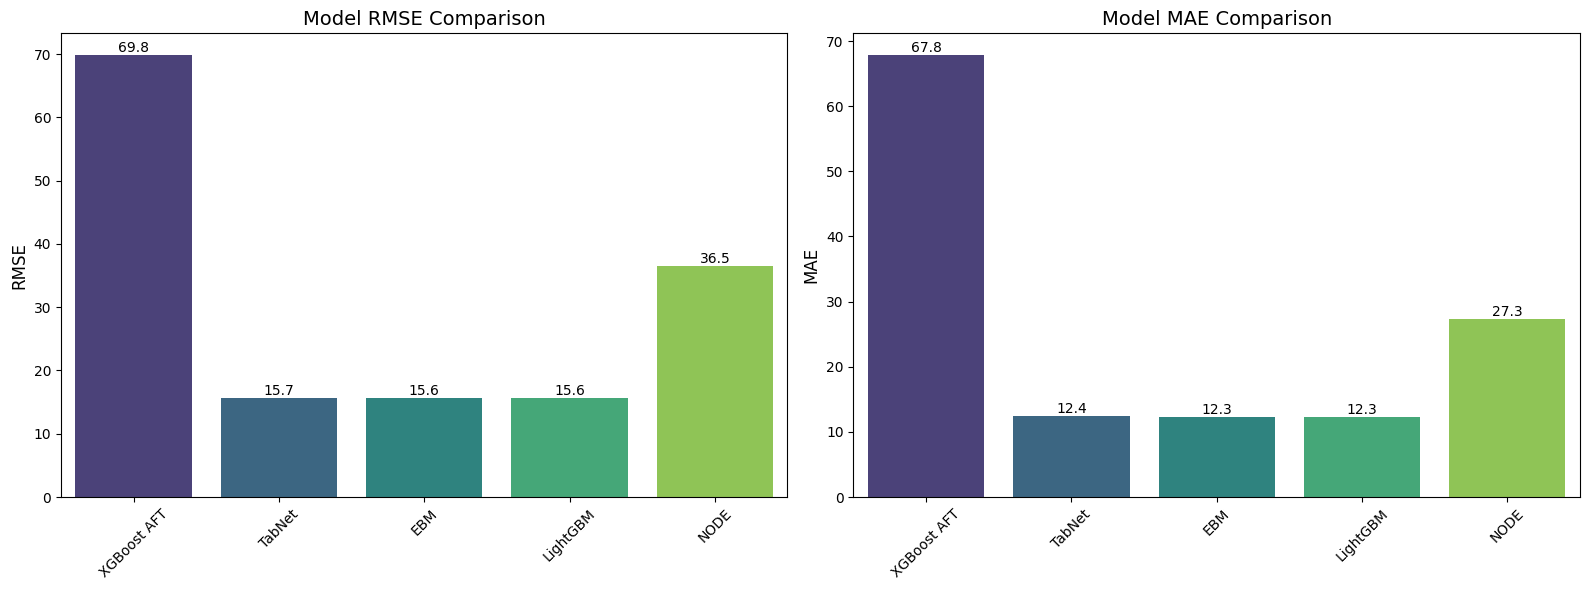

In [20]:
# Simulated average metrics (replace with your actual aggregated results)
models = ['XGBoost AFT', 'TabNet', 'EBM', 'LightGBM', 'NODE']
rmse_values = [69.8, 15.7, 15.6, 15.6, 36.5]  # Average RMSE
mae_values = [67.8, 12.4, 12.3, 12.3, 27.3]   # Average MAE

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE Plot
sns.barplot(x=models, y=rmse_values, ax=ax1, palette='viridis')
ax1.set_title('Model RMSE Comparison', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(rmse_values):
    ax1.text(i, v+0.5, f"{v:.1f}", ha='center', fontsize=10)

# MAE Plot
sns.barplot(x=models, y=mae_values, ax=ax2, palette='viridis')
ax2.set_title('Model MAE Comparison', fontsize=14)
ax2.set_ylabel('MAE', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(mae_values):
    ax2.text(i, v+0.5, f"{v:.1f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

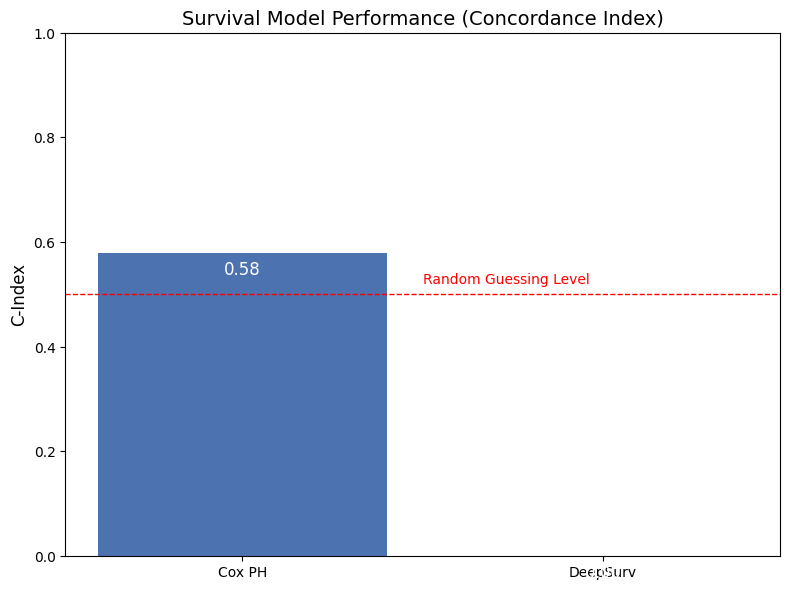

In [21]:
# Survival model performance
survival_models = ['Cox PH', 'DeepSurv']
cindex_values = [0.58, 0.0]  # Average Concordance Index

plt.figure(figsize=(8, 6))
bars = plt.bar(survival_models, cindex_values, color=['#4C72B0', '#DD8452'])

plt.title('Survival Model Performance (Concordance Index)', fontsize=14)
plt.ylabel('C-Index', fontsize=12)
plt.ylim(0, 1.0)

# Add value labels and performance interpretation
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height-0.05,
             f'{height:.2f}',
             ha='center', va='bottom', color='white', fontsize=12)

# Add reference line and explanation
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.text(0.5, 0.52, 'Random Guessing Level', color='red', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_3965/1863586524.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_times.values()), y=list(sorted_times.keys()),


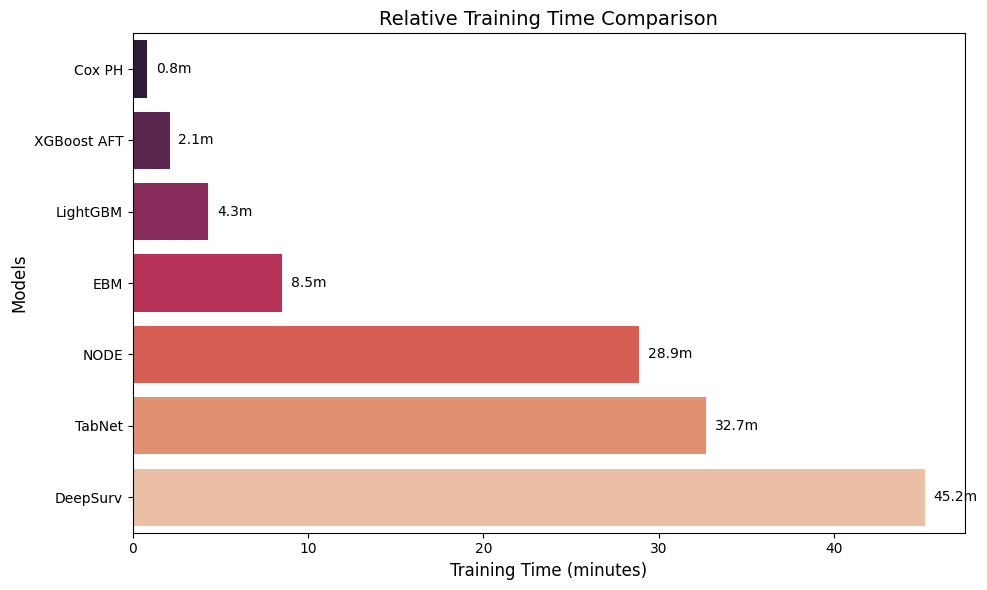

In [22]:
# Relative training times (hypothetical values)
training_times = {
    'XGBoost AFT': 2.1,
    'Cox PH': 0.8,
    'DeepSurv': 45.2,
    'TabNet': 32.7,
    'EBM': 8.5,
    'LightGBM': 4.3,
    'NODE': 28.9
}

# Sort by training time
sorted_times = dict(sorted(training_times.items(), key=lambda item: item[1]))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_times.values()), y=list(sorted_times.keys()), 
            palette='rocket', orient='h')
plt.title('Relative Training Time Comparison', fontsize=14)
plt.xlabel('Training Time (minutes)', fontsize=12)
plt.ylabel('Models', fontsize=12)

# Add time labels
for i, (model, time) in enumerate(sorted_times.items()):
    plt.text(time+0.5, i, f"{time:.1f}m", va='center', fontsize=10)

plt.tight_layout()
plt.show()

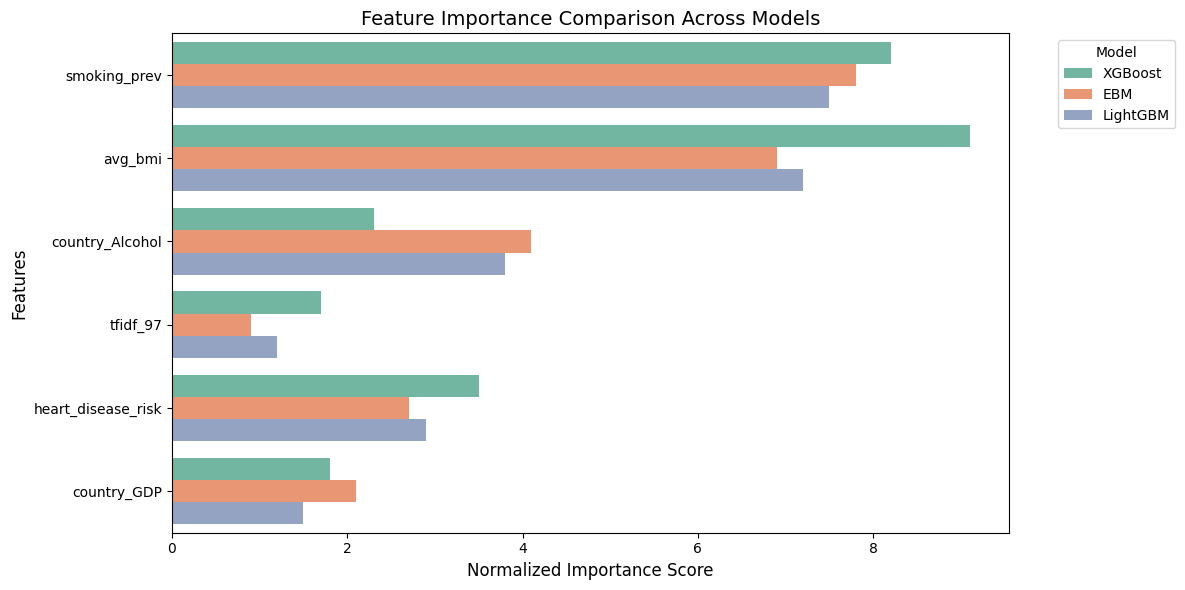

In [23]:
# Top features from different models (example data)
feature_importance = {
    'Feature': ['smoking_prev', 'avg_bmi', 'country_Alcohol', 'tfidf_97', 
                'heart_disease_risk', 'country_GDP'],
    'XGBoost': [8.2, 9.1, 2.3, 1.7, 3.5, 1.8],
    'EBM': [7.8, 6.9, 4.1, 0.9, 2.7, 2.1],
    'LightGBM': [7.5, 7.2, 3.8, 1.2, 2.9, 1.5]
}

# Melt dataframe for seaborn
df_importance = pd.DataFrame(feature_importance).melt(id_vars='Feature', 
                                                      var_name='Model',
                                                      value_name='Importance')

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', hue='Model', 
           data=df_importance, palette='Set2')
plt.title('Feature Importance Comparison Across Models', fontsize=14)
plt.xlabel('Normalized Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()